# Imbalance evaluation

## Imports

In [1]:
import os
from torch import utils
import torch
import numpy as np
import pandas as pd
from sklearn import ensemble
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from sklearn import tree, svm
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer
from src.utils.const import DATA_DIR, SEED
from src.utils.util_models import fix_random
from src.visualization.visualize import barplot_multiple_balancing


### Useful path to data

In [2]:
ROOT_DIR = os.path.join(os.getcwd(), '..')
PROCESSED_DIR = os.path.join(ROOT_DIR, DATA_DIR, 'processed')

### Fix random seed

In [3]:
fix_random(SEED)

## Start to work

In [4]:
final = pd.read_parquet(os.path.join(PROCESSED_DIR, 'final.parquet'))

### Add rating_discrete feature

In [5]:
final = (final
         .assign(rating_discrete=pd.cut(final.loc[:, 'rating_mean'], bins=10, labels=False))
         .astype({'rating_discrete': 'int32'})
         .drop(columns=['rating_mean']))
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13147 entries, 0 to 13146
Columns: 1153 entries, year to rating_discrete
dtypes: float32(1130), float64(1), int32(22)
memory usage: 58.0 MB


### Separate train/test

In [6]:
data = final.loc[:, final.columns != 'rating_discrete']
target = final['rating_discrete']
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2,
                                                                    stratify=final['rating_discrete'])

## Models definition

In [7]:
models ={'random_forest' : ensemble.RandomForestClassifier(),
        'decision_tree' :tree.DecisionTreeClassifier(),
        'GaussianNB' : GaussianNB(),
        'quadratic_discriminant' : QuadraticDiscriminantAnalysis(store_covariance=True),
        'svm': svm.SVC()
         }

Dataset creation, where all the results will be saved inside to be plotted at the end

In [8]:
df=pd.DataFrame({'balance':[],'model_name':[],'mean_acc':[],'mean_f1':[]})

### Training function

In [9]:
def try_sample(train_data_inside, train_target_inside,balance:str) -> None:
    # Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
    global df
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1)
    # Evaluate model
    scoring = ['accuracy', 'f1_weighted']

    results=[]
    for elm in models.items():
        scores = cross_validate(elm[1], train_data_inside, train_target_inside, scoring=scoring, cv=cv, n_jobs=-1)
        # summarize performance
        elemento =pd.DataFrame( {'balance':[balance],'model_name':[elm[0]],'mean_acc': [np.mean(scores['test_accuracy'])],'mean_f1':[np.mean(scores['test_f1_weighted'])]})
        df = pd.concat([df,elemento])
    print(df[df['balance']==balance])


## Transformations

In [10]:
features = [
    'year',
    'title_length',
    'runtime',
    'rating_count',
    'tag_count'
]

scaler = ColumnTransformer(
    remainder='passthrough',
    transformers=[
        ('minmax', MinMaxScaler(), features)
    ])

norm = Normalizer(norm='l2')
pipe = Pipeline(steps=[
    ('scaler', scaler)
    #,('norm', norm) #To review after checks
])

pipe.fit(train_data)
train_data_proc = pipe.transform(train_data)
test_data_proc = pipe.transform(test_data)

### balancer MLP

TODO (?)

In [11]:
def balancer(train_target_tmp: np.ndarray) -> utils.data.WeightedRandomSampler:
    counts = np.bincount(train_target_tmp)
    if counts.any(0):
        np.seterr(divide='ignore')
        labels_weights = 1. / counts
        labels_weights[np.isinf(labels_weights)] = 0
    else:
        np.seterr(divide=None)
        labels_weights = 1. / counts
    weights = torch.tensor(labels_weights[train_target_tmp], dtype=torch.float)
    return utils.data.WeightedRandomSampler(weights, len(weights), replacement=True)

## SMOTE

In [12]:
smt = SMOTE(k_neighbors=4)
train_data_smt_proc, train_target_smt_proc = smt.fit_resample(train_data_proc, train_target)
try_sample(train_data_smt_proc, train_target_smt_proc,'SMOTE')

  balance              model_name  mean_acc   mean_f1
0   SMOTE           random_forest  0.927391  0.927109
0   SMOTE           decision_tree  0.849783  0.848978
0   SMOTE              GaussianNB  0.708199  0.699928
0   SMOTE  quadratic_discriminant  0.815590  0.821285
0   SMOTE                     svm  0.935932  0.935690


## SMOTETomek

In [13]:
smt_tom = SMOTETomek(smote=SMOTE(k_neighbors=4), tomek=TomekLinks(sampling_strategy='majority'))
train_data_smt_tom, train_target_smt_tom = smt_tom.fit_resample(train_data, train_target)
try_sample(train_data_smt_tom, train_target_smt_tom,'SMOTETomek')

      balance              model_name  mean_acc   mean_f1
0  SMOTETomek           random_forest  0.924410  0.924082
0  SMOTETomek           decision_tree  0.839006  0.838577
0  SMOTETomek              GaussianNB  0.442981  0.397841
0  SMOTETomek  quadratic_discriminant  0.734503  0.751558
0  SMOTETomek                     svm  0.201087  0.132469


## SMOTEENN

In [14]:
smt_enn = SMOTEENN(smote=SMOTE(k_neighbors=4), enn=EditedNearestNeighbours(n_neighbors=4))
train_data_smt_enn_proc, train_target_smt_enn_proc = smt_enn.fit_resample(train_data_proc, train_target)
try_sample(train_data_smt_enn_proc, train_target_smt_enn_proc,'SMOTEENN')

    balance              model_name  mean_acc   mean_f1
0  SMOTEENN           random_forest  0.978228  0.974276
0  SMOTEENN           decision_tree  0.932527  0.932182
0  SMOTEENN              GaussianNB  0.828908  0.827278
0  SMOTEENN  quadratic_discriminant  0.899129  0.927695
0  SMOTEENN                     svm  0.980553  0.978840


## RandomOverSampler

In [15]:
rnd_over = RandomOverSampler()
train_data_rnd_over_proc, train_target_rnd_over_proc = rnd_over.fit_resample(train_data_proc, train_target)
try_sample(train_data_rnd_over_proc, train_target_rnd_over_proc,'RandomOverSampler')

             balance              model_name  mean_acc   mean_f1
0  RandomOverSampler           random_forest  0.930031  0.929833
0  RandomOverSampler           decision_tree  0.889037  0.887436
0  RandomOverSampler              GaussianNB  0.683106  0.673043
0  RandomOverSampler  quadratic_discriminant  0.486273  0.491237
0  RandomOverSampler                     svm  0.928540  0.928063


## SMOTE with threshold

#### Min Threshold

In [16]:
bins_count = train_target.value_counts()
for i in range(len(bins_count)):
    if bins_count[i] <= 500:
        bins_count[i] = 500

bin_sizes = bins_count.to_dict()

In [17]:
smt_new = SMOTE(k_neighbors=4, sampling_strategy=bin_sizes)
train_data_smt_new, train_target_smt_new = smt_new.fit_resample(train_data_proc, train_target)
try_sample(train_data_smt_new, train_target_smt_new,'SMOTE_threshold')

           balance              model_name  mean_acc   mean_f1
0  SMOTE_threshold           random_forest  0.785749  0.783859
0  SMOTE_threshold           decision_tree  0.675944  0.675387
0  SMOTE_threshold              GaussianNB  0.522073  0.519197
0  SMOTE_threshold  quadratic_discriminant  0.451456  0.354278
0  SMOTE_threshold                     svm  0.807422  0.806272


## Comparison between models

Saving the results for visualization purpose

In [18]:
df.to_csv(os.path.join(PROCESSED_DIR, 'balancing.csv'))

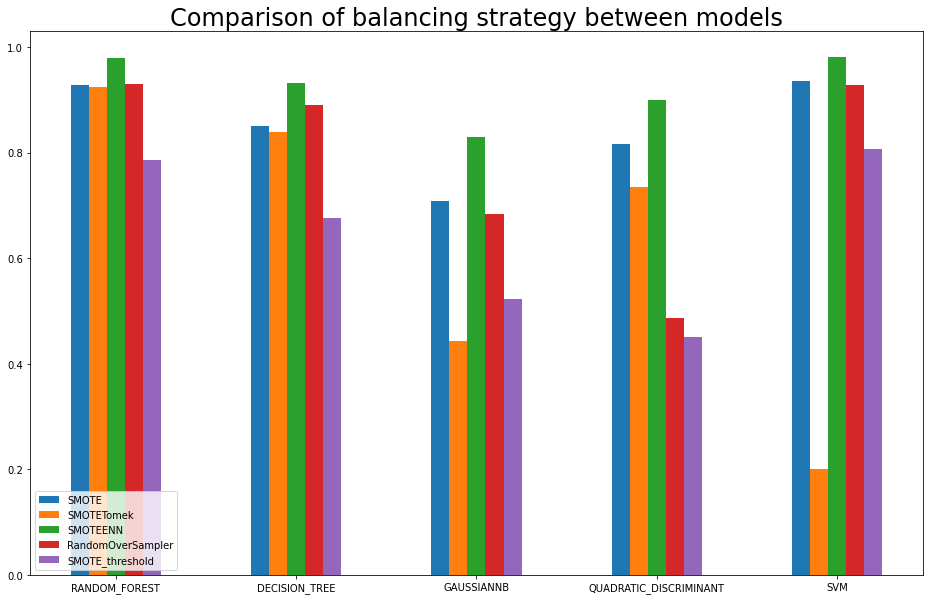

In [19]:
barplot_multiple_balancing(df, 'Comparison of balancing strategy between models')